#Importing Libraries we needed

In [19]:

import os
import sys
import logging
from datetime import datetime
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, classification_report, roc_curve
)



2025-11-08 21:59:13 INFO Environment setup complete
2025-11-08 21:59:13 INFO Environment setup complete


# give path of dataset

In [9]:

DATA_PATH = (r"D:\python\automatic\csv files\advertising.csv"  )
df = pd.read_csv(DATA_PATH)
logging.info(f"Loaded data from {DATA_PATH}, shape: {df.shape}")
df.head()


2025-11-08 21:50:51 INFO Loaded data from D:\python\automatic\csv files\advertising.csv, shape: (1000, 10)


,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Ad Topic Line,City,Male,Country,Timestamp,Clicked on Ad
0,68.95,35,61833.90,256.09,Cloned 5thgeneration orchestration,Wrightburgh,0,Tunisia,2016-03-27 00:53:11,0
1,80.23,31,68441.85,193.77,Monitored national standardization,West Jodi,1,Nauru,2016-04-04 01:39:02,0
2,69.47,26,59785.94,236.50,Organic bottom-line service-desk,Davidton,0,San Marino,2016-03-13 20:35:42,0
3,74.15,29,54806.18,245.89,Triple-buffered reciprocal time-frame,West Terrifurt,1,Italy,2016-01-10 02:31:19,0
4,68.37,35,73889.99,225.58,Robust logistical utilization,South Manuel,0,Iceland,2016-06-03 03:36:18,0


#Load data & quick cheaking of data set

In [10]:

print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
print("Missing values:\n", df.isna().sum())
print("Duplicates:", df.duplicated().sum())


n_dup_before = df.duplicated().sum()
if n_dup_before > 0:
    df = df.drop_duplicates().reset_index(drop=True)
    logging.info(f"Dropped {n_dup_before} duplicated rows. New shape: {df.shape}")


Shape: (1000, 10)
Columns: ['Daily Time Spent on Site', 'Age', 'Area Income', 'Daily Internet Usage', 'Ad Topic Line', 'City', 'Male', 'Country', 'Timestamp', 'Clicked on Ad']
Missing values:
 Daily Time Spent on Site    0
Age                         0
Area Income                 0
Daily Internet Usage        0
Ad Topic Line               0
City                        0
Male                        0
Country                     0
Timestamp                   0
Clicked on Ad               0
dtype: int64
Duplicates: 0


#Exploratory Data Analysis and visualization

Clicked on Ad
0    0.5
1    0.5
Name: proportion, dtype: float64
2025-11-08 21:52:08 INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-11-08 21:52:08 INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


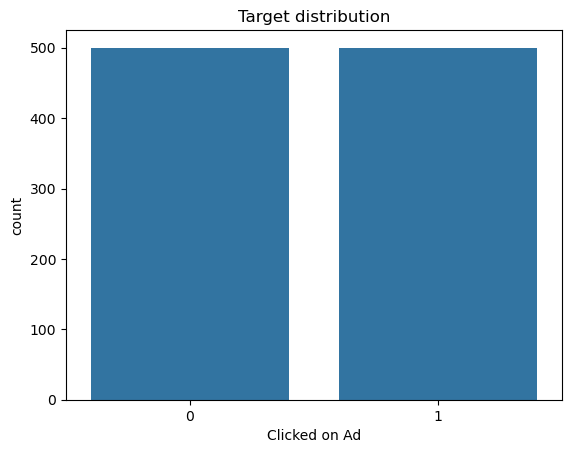

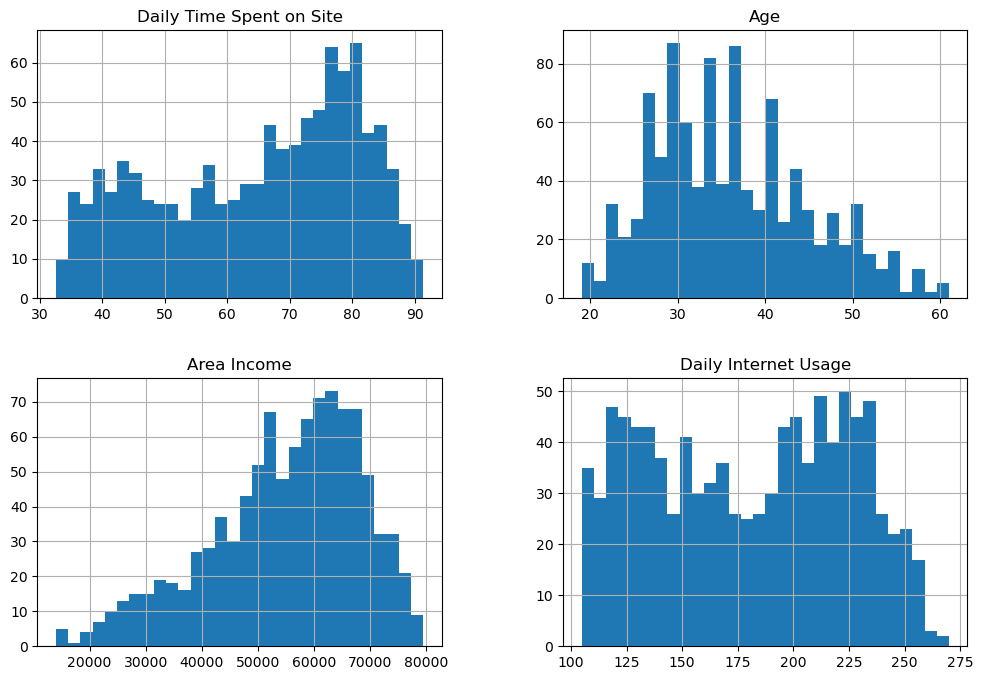

2025-11-08 21:52:10 INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-11-08 21:52:10 INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


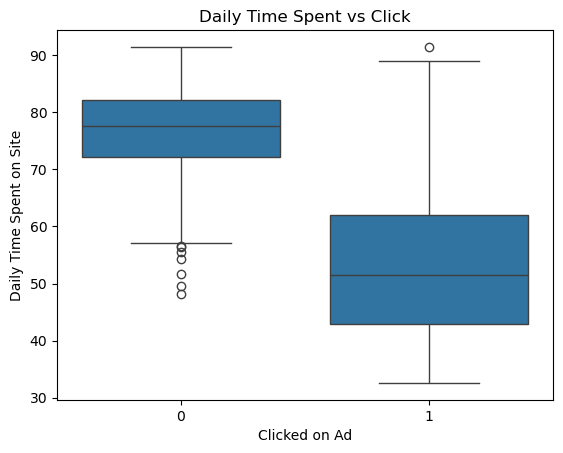

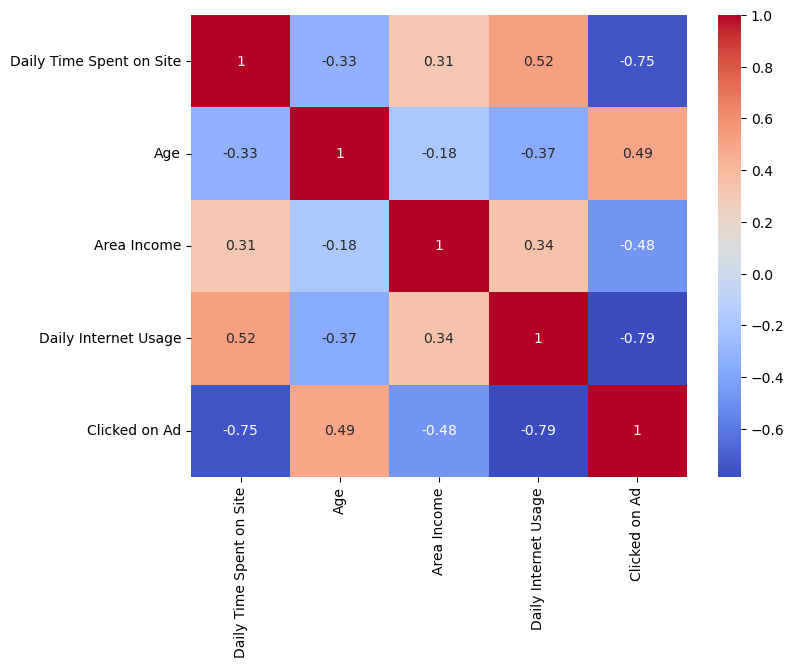

In [11]:

import matplotlib.pyplot as plt
%matplotlib inline


target_col = "Clicked on Ad" 
print(df[target_col].value_counts(normalize=True))
sns.countplot(x=target_col, data=df)
plt.title("Target distribution")
plt.show()


num_cols = ["Daily Time Spent on Site", "Age", "Area Income", "Daily Internet Usage"]
df[num_cols].hist(bins=30, figsize=(12,8))
plt.show()


sns.boxplot(x=target_col, y="Daily Time Spent on Site", data=df)
plt.title("Daily Time Spent vs Click")
plt.show()


plt.figure(figsize=(8,6))
sns.heatmap(df[num_cols + [target_col]].corr(), annot=True, cmap="coolwarm")
plt.show()


In [12]:

print(df["Male"].value_counts() if "Male" in df.columns else "No Male column")
print(df["Country"].value_counts().head(10) if "Country" in df.columns else "No Country")
print("Sample Ad Topic Lines:")
print(df["Ad Topic Line"].sample(10).values)


Male
0    519
1    481
Name: count, dtype: int64
Country
Czech Republic    9
France            9
Senegal           8
Peru              8
Greece            8
Micronesia        8
Liberia           8
Turkey            8
Afghanistan       8
South Africa      8
Name: count, dtype: int64
Sample Ad Topic Lines:
['Customizable holistic archive'
 'Self-enabling zero administration neural-net'
 'Quality-focused maximized extranet' 'Organic logistical adapter'
 'Inverse high-level capability' 'Digitized interactive initiative'
 'Implemented disintermediate attitude'
 'Upgradable heuristic system engine' 'Managed national hardware'
 'Multi-layered user-facing paradigm']


In [22]:

df = df.copy()


if "Timestamp" in df.columns:
    df["Timestamp"] = pd.to_datetime(df["Timestamp"])
    
    df["hour"] = df["Timestamp"].dt.hour
    df["dayofweek"] = df["Timestamp"].dt.dayofweek


if "Ad Topic Line" in df.columns:
    df["ad_topic_len"] = df["Ad Topic Line"].astype(str).apply(len)
   
    df["ad_topic_words"] = df["Ad Topic Line"].astype(str).apply(lambda x: len(x.split()))


if "Male" in df.columns:
    df["gender"] = df["Male"].map({1: "male", 0: "female"})
    df.drop(columns=["Male"], inplace=True)


cols_to_drop = []
for col in ["City", "Ad Topic Line", "Timestamp"]:
    if col in df.columns:
        cols_to_drop.append(col)
df.drop(columns=cols_to_drop, inplace=True)
logging.info(f"Dropped columns: {cols_to_drop}")

df.head()


2025-11-08 22:04:52 INFO Dropped columns: []
2025-11-08 22:04:52 INFO Dropped columns: []


,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Country,Clicked on Ad,hour,dayofweek,ad_topic_len,ad_topic_words,gender
0,68.95,35,61833.90,256.09,Tunisia,0,0,6,34,3,female
1,80.23,31,68441.85,193.77,Nauru,0,1,0,34,3,male
2,69.47,26,59785.94,236.50,San Marino,0,20,6,32,3,female
3,74.15,29,54806.18,245.89,Italy,0,2,6,37,3,male
4,68.37,35,73889.99,225.58,Iceland,0,3,4,29,3,female


In [24]:

target = "Clicked on Ad"
all_features = [c for c in df.columns if c != target]
numeric_features = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_features = [c for c in numeric_features if c != target]

categorical_features = [c for c in df.columns if c not in numeric_features + [target]]
logging.info(f"Numeric: {numeric_features}, Categorical: {categorical_features}")


2025-11-08 22:05:15 INFO Numeric: ['Daily Time Spent on Site', 'Age', 'Area Income', 'Daily Internet Usage', 'hour', 'dayofweek', 'ad_topic_len', 'ad_topic_words'], Categorical: ['Country', 'gender']
2025-11-08 22:05:15 INFO Numeric: ['Daily Time Spent on Site', 'Age', 'Area Income', 'Daily Internet Usage', 'hour', 'dayofweek', 'ad_topic_len', 'ad_topic_words'], Categorical: ['Country', 'gender']


In [34]:

from sklearn.impute import SimpleImputer

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
   ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))

])

preprocessor = ColumnTransformer(transformers=[
    ("num", numeric_transformer, numeric_features),
    ("cat", categorical_transformer, categorical_features)
], remainder='drop')


In [26]:
# cell 9
X = df[all_features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=RANDOM_STATE, stratify=y
)
logging.info(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")


2025-11-08 22:06:01 INFO Train shape: (750, 10), Test shape: (250, 10)
2025-11-08 22:06:01 INFO Train shape: (750, 10), Test shape: (250, 10)


In [35]:

lr_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("clf", LogisticRegression(random_state=RANDOM_STATE, max_iter=1000))
])

lr_pipeline.fit(X_train, y_train)
y_pred = lr_pipeline.predict(X_test)
y_proba = lr_pipeline.predict_proba(X_test)[:,1]


acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc = roc_auc_score(y_test, y_proba)
logging.info(f"Logistic Regression metrics - ACC: {acc:.4f}, PREC: {prec:.4f}, REC: {rec:.4f}, F1: {f1:.4f}, AUC: {roc:.4f}")

print(classification_report(y_test, y_pred))


2025-11-08 22:08:53 INFO Logistic Regression metrics - ACC: 0.9760, PREC: 0.9837, REC: 0.9680, F1: 0.9758, AUC: 0.9908
2025-11-08 22:08:53 INFO Logistic Regression metrics - ACC: 0.9760, PREC: 0.9837, REC: 0.9680, F1: 0.9758, AUC: 0.9908
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       125
           1       0.98      0.97      0.98       125

    accuracy                           0.98       250
   macro avg       0.98      0.98      0.98       250
weighted avg       0.98      0.98      0.98       250

